## Simple grid search model for seismic surface event location

In [1]:
# import modules
from geopy import distance
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define function to predict synthetic arrival times
def travel_time(t0, x, y, vs, sta_x, sta_y):
    dist = np.sqrt((sta_x - x)**2 + (sta_y - y)**2)
    tt = t0 + dist/vs
    return tt

# define function to compute residual sum of squares
def error(synth_arrivals,arrivals):
    res = arrivals - synth_arrivals   #make sure arrivals are in the right order, maybe iterate through keys
    res_sqr = res**2
    rss = np.sum(res_sqr)
    return rss

# define function to iterate through grid and calculate travel time residuals
def gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals):
    rss_mat = np.zeros((len(t0),len(x_vect),len(y_vect)))
    rss_mat[:,:,:] = np.nan
    for i in range(len(t0)):
        for j in range(len(x_vect)):
            for k in range(len(y_vect)):
                synth_arrivals = []
                for h in range(len(sta_x)):
                    tt = travel_time(t0[i],x_vect[j],y_vect[k],vs,sta_x[h],sta_y[h])
                    synth_arrivals.append(tt)
                rss = error(np.array(synth_arrivals),np.array(arrivals))
                rss_mat[i,j,k] = rss
    return rss_mat

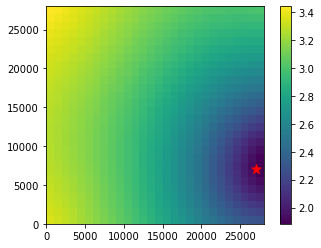

In [10]:
# define input parameters
arrivals = [30, 35, 15, 1]
sta_lats = [60,60.25,60.25,60] 
sta_lons = [80,80,80.5,80.5]
vs = 1000

# define grid origin in lat,lon and grid dimensions in m
lat_start = 60
lon_start = 80
grid_length = 2.8e4
grid_height = 2.8e4
step = 1000
t_step = 1

sta_x = []
sta_y = []
for i in range(len(sta_lats)):
    x_dist = distance.distance([lat_start,lon_start],[lat_start,sta_lons[i]]).m
    y_dist = distance.distance([lat_start,lon_start],[sta_lats[i],lon_start]).m
    sta_x.append(x_dist)
    sta_y.append(y_dist)

# set grid points
x_vect = np.arange(0, grid_length, step)
y_vect = np.arange(0, grid_height, step)
t0 = np.arange(0,np.max(arrivals),t_step)

# carry out the gridsearch
rss_mat = gridsearch(t0,x_vect,y_vect,sta_x,sta_y,vs,arrivals)

# find lowest error lat, lon, and origin time
loc_idx = np.unravel_index(np.argmin(rss_mat), rss_mat.shape)

# plot a spatial map of error for lowest-error origin time
fig,ax = plt.subplots()
ax.scatter(x_vect[loc_idx[1]],y_vect[loc_idx[2]],s=100,marker='*',c='r')

im = ax.imshow(np.log10(rss_mat[loc_idx[0],:,:].T),origin="lower",extent=[0,grid_length,0,grid_height])
fig.colorbar(im)
plt.show()

In [4]:
# some other useful bits of code

# define a general distance object
dx = distance.geodesic(meters = grid_length)
dy = distance.geodesic(meters = grid_height)

# go dx meters east of grid origin and dy meters north of grid origin
lon_stop = dx.destination(point=[lat_start,lon_start], bearing=90)[1]
lat_stop = dy.destination(point=[lat_start,lon_start], bearing=0)[0]